In [81]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as pt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import numpy as np
import torchvision
import tqdm

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [83]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Shift images
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),  # Random crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder('./data/train', transform=train_transforms)
test_dataset = datasets.ImageFolder('./data/test', transform=test_transforms)

In [84]:
class_counts = [len(np.where(np.array(train_dataset.targets) == i)[0]) for i in range(7)]
weights = 1. / np.array(class_counts)
sample_weights = weights[train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [85]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
class FER_CNN(nn.Module):
    def __init__(self):
        super(FER_CNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2,2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*3*3,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,256),

            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256,7)
        )

    def forward(self, x):
        x = self.network(x)
        x = self.fc_layers(x)

        return x

In [87]:
model = FER_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [88]:
def train_model(epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for input, labels in train_loader:
            input, labels = input.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = evaluate_loss(test_loader)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {running_loss/len(train_loader):.4f}, Val Loss = {val_loss:.4f}")


In [89]:
def evaluate_loss(loader):
    model.eval()
    loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
    return loss / len(loader)

In [90]:
def evaluate_model():
    model.eval()
    predictions, trues = [],[]
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs,1)
            predictions.extend(predicted.cpu().numpy())
            trues.extend(labels.numpy())
    acc = accuracy_score(trues, predictions)
    f1 = f1_score(trues, predictions, average='weighted')
    print(f"Test Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

    cm = confusion_matrix(trues, predictions)
    pt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
    pt.xlabel('Predicted')
    pt.ylabel('True')
    pt.title('Confusion Matrix')
    pt.show()

Epoch 1/20: Train Loss = 1.9416, Val Loss = 1.8433
Epoch 2/20: Train Loss = 1.7634, Val Loss = 1.5429
Epoch 3/20: Train Loss = 1.6114, Val Loss = 1.4208
Epoch 4/20: Train Loss = 1.4937, Val Loss = 1.3366
Epoch 5/20: Train Loss = 1.4228, Val Loss = 1.3004
Epoch 6/20: Train Loss = 1.3796, Val Loss = 1.2595
Epoch 7/20: Train Loss = 1.3377, Val Loss = 1.2638
Epoch 8/20: Train Loss = 1.2998, Val Loss = 1.2458
Epoch 9/20: Train Loss = 1.2788, Val Loss = 1.1747
Epoch 10/20: Train Loss = 1.2452, Val Loss = 1.1732
Epoch 11/20: Train Loss = 1.2151, Val Loss = 1.2594
Epoch 12/20: Train Loss = 1.2088, Val Loss = 1.1637
Epoch 13/20: Train Loss = 1.1993, Val Loss = 1.1581
Epoch 14/20: Train Loss = 1.1699, Val Loss = 1.1259
Epoch 15/20: Train Loss = 1.1593, Val Loss = 1.1185
Epoch 16/20: Train Loss = 1.1502, Val Loss = 1.1017
Epoch 17/20: Train Loss = 1.1251, Val Loss = 1.0803
Epoch 18/20: Train Loss = 1.1159, Val Loss = 1.0991
Epoch 19/20: Train Loss = 1.1123, Val Loss = 1.1055
Epoch 20/20: Train Lo

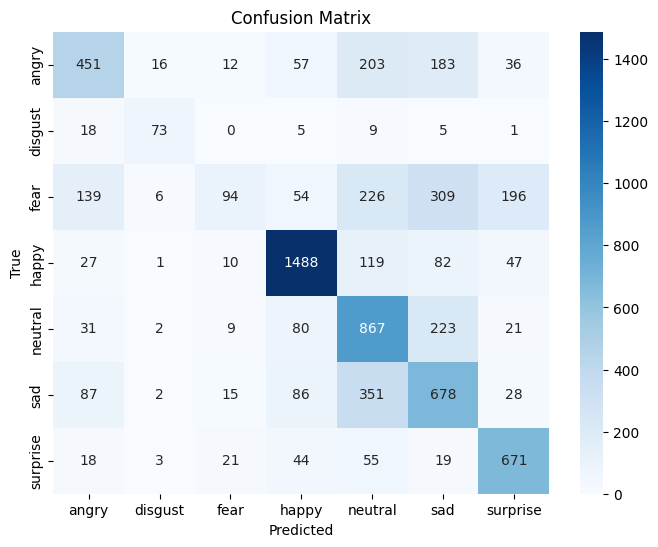

In [91]:
train_model(epochs=20)
evaluate_model()

torch.save(model.state_dict(), 'HumanEmotions.pth')